This notebook contains the code used in the BigComp 2022 paper: <br>
<b>Heeryon Cho, Woo-Kyu Kang, Younsoo Park, Sungeu Chae, and Seong-joon Kim, "Multi-label Facial Emotion Recognition Using Korean Drama Movie Clips," BigComp 2022.</b>
### Convert tfrecords into images & Analyze image labels

In [1]:
import os
import pandas as pd
import random as rn
import numpy as np
from collections import Counter
from IPython.display import display, Image
import tensorflow as tf

In [2]:
# Record cell run time.
#!pip install ipython-autotime

%load_ext autotime

time: 214 µs (started: 2021-12-07 12:50:48 +00:00)


## 1. Convert tfrecord file into images

In [3]:
# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([6], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

raw_image_dataset = tf.data.TFRecordDataset('./tfrecords/6_basic_emo_test.tfrecords')

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {depth: (), height: (), image_raw: (), label: (6,), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>

time: 1.3 s (started: 2021-12-07 12:50:48 +00:00)


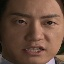

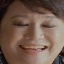

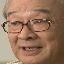

Number of images displayed: 3
time: 65.2 ms (started: 2021-12-07 12:50:49 +00:00)


In [4]:
n = 0
for image_features in parsed_image_dataset.take(3):
    image_raw = image_features['image_raw'].numpy()
    display(Image(data=image_raw))
    n += 1
print("Number of images displayed:", n)

## 2. Analyze emotion labels.

### Read emotion labels.

In [5]:
# Load labels, check headers, check data shape.

df_label = pd.read_csv('label/label_multi-label.csv')
print(df_label.columns)
print(df_label.shape)

LABELS = list(df_label.columns[2:])
print("LABELS=", LABELS)
print(len(LABELS))

Index(['img_id', 'clip_id', 'moved', 'fearful', 'bored', 'surprised', 'angry',
       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
       'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful',
       'happy', 'disgusted'],
      dtype='object')
(38817, 26)
LABELS= ['moved', 'fearful', 'bored', 'surprised', 'angry', 'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled', 'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed', 'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful', 'happy', 'disgusted']
24
time: 84.8 ms (started: 2021-12-07 12:50:49 +00:00)


In [6]:
# Place label data into a dictionary.

dict_label = {}
for idx, row in df_label.iterrows():
    dict_label[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label)

38817

time: 7.72 s (started: 2021-12-07 12:50:49 +00:00)


In [7]:
# Display one image label.

dict_label['03_00001-1_00001.jpg']

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

time: 2.93 ms (started: 2021-12-07 12:50:57 +00:00)


In [8]:
# List unique labels.

uniq_labels = [list(x) for x in set(tuple(x) for x in list(dict_label.values()))]
uniq_labels.sort()
len(uniq_labels)

158

time: 39 ms (started: 2021-12-07 12:50:57 +00:00)


In [9]:
# Convert list-format labels into string-format labels.

uniq_labels_strs = [str(x) for x in list(dict_label.values())]
uniq_labels_strs[0]

'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]'

time: 72.9 ms (started: 2021-12-07 12:50:57 +00:00)


In [10]:
# Count unique label frequency.

uniq_label_counts = Counter(uniq_labels_strs)
uniq_label_counts
sorted_uniq_label_counts = dict(sorted(uniq_label_counts.items()))
sorted_uniq_label_counts

{'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]': 117,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]': 185,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]': 153,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]': 252,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]': 174,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]': 474,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]': 427,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]': 44,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]': 25,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]': 455,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]': 1030,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]': 2,
 '[0, 0, 0, 0, 0, 0

time: 11.6 ms (started: 2021-12-07 12:50:57 +00:00)


In [11]:
# Double check the total numbers.

sum(sorted_uniq_label_counts.values())

38817

time: 2.68 ms (started: 2021-12-07 12:50:57 +00:00)


In [12]:
# Select one unique label.

uniq_labels[10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]

time: 3.36 ms (started: 2021-12-07 12:50:57 +00:00)


In [13]:
# Retrieve index where label value equals one.

all_indices = [i for i,x in enumerate(uniq_labels[10]) if x == 1]
all_indices

[16, 22]

time: 3.89 ms (started: 2021-12-07 12:50:57 +00:00)


In [14]:
# Retrieve emotion words using indices.

emotions = [LABELS[i] for i in all_indices]
emotions

['amused', 'happy']

time: 5.33 ms (started: 2021-12-07 12:50:57 +00:00)


### Count total number of labels with 1, 2, 3, and 4 emotions.

In [15]:
count_n_labels = []
count_1_emotion = []
count_1_emotion_sum = 0
count_2_emotion = []
count_2_emotion_sum = 0
count_3_emotion = []
count_3_emotion_sum = 0
count_4_emotion = []
count_4_emotion_sum = 0
count_multi_emotion = []
count_multi_emotion_sum = 0
for k, v in sorted_uniq_label_counts.items():
    str_list = k[1:-1].split(', ')
    label_list = [int(i) for i in str_list]
    all_indices = [i for i,x in enumerate(label_list) if x == 1]
    emotions = [LABELS[i] for i in all_indices]
    count_n_labels.append([v] + emotions)
    
    if len(emotions) == 1:
        count_1_emotion.append([v] + emotions)
        count_1_emotion_sum += v
    
    if len(emotions) == 2:
        count_2_emotion.append([v] + emotions)
        count_2_emotion_sum += v

    if len(emotions) == 3:
        count_3_emotion.append([v] + emotions)
        count_3_emotion_sum += v

    if len(emotions) == 4:
        count_4_emotion.append([v] + emotions)
        count_4_emotion_sum += v
        
    if len(emotions) > 1:
        count_multi_emotion.append([v] + emotions)
        count_multi_emotion_sum += v    
        
count_n_labels.sort(reverse=True)
print(len(count_n_labels))
count_n_labels

158


[[7586, 'angry'],
 [2715, 'surprised'],
 [1930, 'sad'],
 [1702, 'upset'],
 [1646, 'sad', 'depressed'],
 [1440, 'sad', 'upset'],
 [1198, 'angry', 'upset'],
 [1107, 'angry', 'sad'],
 [1030, 'amused', 'happy'],
 [951, 'anxious'],
 [926, 'smitten', 'happy'],
 [918, 'disappointed'],
 [817, 'smitten', 'fluttered'],
 [790, 'sad', 'sympathetic'],
 [729, 'upset', 'depressed'],
 [658, 'angry', 'disgusted'],
 [590, 'angry', 'disappointed'],
 [562, 'disappointed', 'upset'],
 [523, 'upset', 'guilty'],
 [509, 'sympathetic'],
 [474, 'guilty'],
 [455, 'amused'],
 [427, 'affectionate'],
 [404, 'disappointed', 'sad'],
 [312, 'moved'],
 [308, 'smitten', 'sympathetic'],
 [300, 'smitten'],
 [280, 'sad', 'guilty'],
 [280, 'fearful'],
 [252, 'peaceful', 'happy'],
 [229, 'angry', 'jealous'],
 [224, 'fearful', 'anxious', 'passionate'],
 [207, 'disappointed', 'jealous'],
 [202, 'depressed'],
 [186, 'surprised', 'upset'],
 [185, 'sad', 'upset', 'depressed'],
 [185, 'happy'],
 [185, 'angry', 'guilty'],
 [183, 'sm

time: 22.2 ms (started: 2021-12-07 12:50:57 +00:00)


<b>1. Number of labels with one emotion only.</b>

In [16]:
count_1_emotion.sort(reverse=True)
print("--- 1 label total:", count_1_emotion_sum)
print("--- 1 label uniq:", len(count_1_emotion))
count_1_emotion

--- 1 label total: 19800
--- 1 label uniq: 22


[[7586, 'angry'],
 [2715, 'surprised'],
 [1930, 'sad'],
 [1702, 'upset'],
 [951, 'anxious'],
 [918, 'disappointed'],
 [509, 'sympathetic'],
 [474, 'guilty'],
 [455, 'amused'],
 [427, 'affectionate'],
 [312, 'moved'],
 [300, 'smitten'],
 [280, 'fearful'],
 [202, 'depressed'],
 [185, 'happy'],
 [174, 'jealous'],
 [160, 'fluttered'],
 [153, 'peaceful'],
 [149, 'fulfilled'],
 [117, 'disgusted'],
 [73, 'ashamed'],
 [28, 'passionate']]

time: 5.48 ms (started: 2021-12-07 12:50:57 +00:00)


<b>2. Number of labels with two emotions.</b>

In [17]:
count_2_emotion.sort(reverse=True)
print("--- 2 labels total:", count_2_emotion_sum)
print("--- 2 labels uniq:", len(count_2_emotion))
count_2_emotion

--- 2 labels total: 18134
--- 2 labels uniq: 108


[[1646, 'sad', 'depressed'],
 [1440, 'sad', 'upset'],
 [1198, 'angry', 'upset'],
 [1107, 'angry', 'sad'],
 [1030, 'amused', 'happy'],
 [926, 'smitten', 'happy'],
 [817, 'smitten', 'fluttered'],
 [790, 'sad', 'sympathetic'],
 [729, 'upset', 'depressed'],
 [658, 'angry', 'disgusted'],
 [590, 'angry', 'disappointed'],
 [562, 'disappointed', 'upset'],
 [523, 'upset', 'guilty'],
 [404, 'disappointed', 'sad'],
 [308, 'smitten', 'sympathetic'],
 [280, 'sad', 'guilty'],
 [252, 'peaceful', 'happy'],
 [229, 'angry', 'jealous'],
 [207, 'disappointed', 'jealous'],
 [186, 'surprised', 'upset'],
 [185, 'angry', 'guilty'],
 [183, 'smitten', 'sad'],
 [173, 'anxious', 'sad'],
 [168, 'fearful', 'surprised'],
 [158, 'fearful', 'anxious'],
 [152, 'surprised', 'sad'],
 [150, 'smitten', 'amused'],
 [146, 'sad', 'affectionate'],
 [134, 'angry', 'depressed'],
 [133, 'sympathetic', 'guilty'],
 [122, 'angry', 'ashamed'],
 [118, 'sympathetic', 'affectionate'],
 [105, 'upset', 'sympathetic'],
 [95, 'anxious', 'up

time: 13.6 ms (started: 2021-12-07 12:50:57 +00:00)


<b>3. Number of labels with three emotions.</b>

In [18]:
count_3_emotion.sort(reverse=True)
print("--- 3 labels total:", count_3_emotion_sum)
print("--- 3 labels uniq:", len(count_3_emotion))
count_3_emotion

--- 3 labels total: 875
--- 3 labels uniq: 27


[[224, 'fearful', 'anxious', 'passionate'],
 [185, 'sad', 'upset', 'depressed'],
 [74, 'sad', 'sympathetic', 'affectionate'],
 [43, 'sad', 'upset', 'sympathetic'],
 [40, 'angry', 'sad', 'upset'],
 [35, 'disappointed', 'sad', 'upset'],
 [32, 'angry', 'upset', 'disgusted'],
 [27, 'fearful', 'anxious', 'sad'],
 [26, 'smitten', 'disappointed', 'affectionate'],
 [23, 'smitten', 'fluttered', 'sympathetic'],
 [23, 'disappointed', 'sad', 'disgusted'],
 [20, 'smitten', 'amused', 'happy'],
 [20, 'anxious', 'upset', 'happy'],
 [15, 'fearful', 'upset', 'guilty'],
 [12, 'sad', 'sympathetic', 'guilty'],
 [12, 'anxious', 'upset', 'passionate'],
 [11, 'angry', 'anxious', 'affectionate'],
 [10, 'anxious', 'fluttered', 'affectionate'],
 [8, 'moved', 'smitten', 'fluttered'],
 [7, 'fearful', 'surprised', 'upset'],
 [7, 'fearful', 'angry', 'upset'],
 [7, 'angry', 'sad', 'guilty'],
 [4, 'smitten', 'fluttered', 'amused'],
 [4, 'angry', 'anxious', 'upset'],
 [3, 'amused', 'affectionate', 'happy'],
 [2, 'anxio

time: 6.82 ms (started: 2021-12-07 12:50:57 +00:00)


<b>4. Number of labels with four emotions.</b>

In [19]:
count_4_emotion.sort(reverse=True)
print("--- 4 labels total:", count_4_emotion_sum)
print("--- 4 labels uniq:", len(count_4_emotion))
count_4_emotion

--- 4 labels total: 8
--- 4 labels uniq: 1


[[8, 'surprised', 'angry', 'sad', 'upset']]

time: 4.25 ms (started: 2021-12-07 12:50:57 +00:00)


In [20]:
count_multi_emotion.sort(reverse=True)
print("--- Multi-label total:", count_multi_emotion_sum)
print("--- Multi-label uniq:", len(count_multi_emotion))
count_multi_emotion

--- Multi-label total: 19017
--- Multi-label uniq: 136


[[1646, 'sad', 'depressed'],
 [1440, 'sad', 'upset'],
 [1198, 'angry', 'upset'],
 [1107, 'angry', 'sad'],
 [1030, 'amused', 'happy'],
 [926, 'smitten', 'happy'],
 [817, 'smitten', 'fluttered'],
 [790, 'sad', 'sympathetic'],
 [729, 'upset', 'depressed'],
 [658, 'angry', 'disgusted'],
 [590, 'angry', 'disappointed'],
 [562, 'disappointed', 'upset'],
 [523, 'upset', 'guilty'],
 [404, 'disappointed', 'sad'],
 [308, 'smitten', 'sympathetic'],
 [280, 'sad', 'guilty'],
 [252, 'peaceful', 'happy'],
 [229, 'angry', 'jealous'],
 [224, 'fearful', 'anxious', 'passionate'],
 [207, 'disappointed', 'jealous'],
 [186, 'surprised', 'upset'],
 [185, 'sad', 'upset', 'depressed'],
 [185, 'angry', 'guilty'],
 [183, 'smitten', 'sad'],
 [173, 'anxious', 'sad'],
 [168, 'fearful', 'surprised'],
 [158, 'fearful', 'anxious'],
 [152, 'surprised', 'sad'],
 [150, 'smitten', 'amused'],
 [146, 'sad', 'affectionate'],
 [134, 'angry', 'depressed'],
 [133, 'sympathetic', 'guilty'],
 [122, 'angry', 'ashamed'],
 [118, 'sy

time: 18.8 ms (started: 2021-12-07 12:50:57 +00:00)


In [21]:
# Double check total count.

total_count = count_1_emotion_sum + count_2_emotion_sum + count_3_emotion_sum + count_4_emotion_sum
total_count

38817

time: 2.56 ms (started: 2021-12-07 12:50:57 +00:00)


In [22]:
# Double check unique emotion labels.

total_uniq_emotion = len(count_1_emotion) + len(count_2_emotion) + len(count_3_emotion) + len(count_4_emotion)
total_uniq_emotion

158

time: 2.91 ms (started: 2021-12-07 12:50:57 +00:00)
